This notebook is an interactive application that allows you to view/explore a price attribution dataset. Once you specify the directory where the dataset is located, you can view each graph in the dataset (annotated with the ground truth product-price connections).

Two views are displayed:

1. A graph view, where each node is a product or price tag detection, and the depicted edges connect product and price nodes that have been labeled as part of the same pricing group.
2. A visual view, where we show the display image the detections were computed from, with colors indicating which products/prices are in the same labeled pricing group. Note that in this view, any individual product / price bboxes that are not in a pricing group are colored in white. Product bboxes are plotted with solid lines, while price bboxes are plotted with dashed lines.

In [1]:
import os
import sys
from pathlib import Path
from typing import Literal

sys.path.append(str(Path(os.getcwd()).parent))

import pandas as pd
import torch
from ipywidgets import widgets
from matplotlib import pyplot as plt
from seaborn import color_palette

from gpa.common.helpers import plot_bboxes, parse_into_subgraphs
from gpa.datasets.attribution import DetectionGraph
from gpa.datasets.attribution import PriceAttributionDataset

In [2]:
torch.serialization.add_safe_globals([DetectionGraph])
dataset_dir = Path("../data/swire/train")
dataset = PriceAttributionDataset(root=dataset_dir)
products_df = pd.read_csv(dataset_dir / "raw"/ "product_boxes.csv", index_col="attributionset_id")

/Users/stocktonjenkins/src/delicious/gpa/.venv/lib/python3.10/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([__main__.DetectionGraph])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


In [4]:
def plot_scene_graph(idx: int, dataset: PriceAttributionDataset, grouping: Literal["upc", "category_packaging", "brand"]):
    plt.close()
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    graph: DetectionGraph = dataset[idx]
    
    graph.edge_index = graph.gt_prod_price_edge_index
    graph.edge_attr = torch.ones(graph.edge_index.shape[1])
    graph.plot(ax=axs[0], prod_price_only=True, mark_wrong_edges=True)
    axs[0].set_title(graph.graph_id, fontsize=10)

    image_path = dataset_dir.parent / products_df.loc[graph.graph_id]["local_path"].values[0]
    image = plt.imread(image_path)

    height, width = image.shape[:2]

    subgraph_indices = (
        graph.upc_groups
        if grouping == "upc"
        else graph.brand_groups
        if grouping == "brand"
        else graph.category_groups
        if grouping == "category_packaging"
        else parse_into_subgraphs(graph.edge_index, graph.num_nodes)
    )
    subgraph_ids = torch.unique(subgraph_indices)
    colors = color_palette(n_colors=len(subgraph_ids))
    for i, color in zip(subgraph_ids, colors):
        node_indices = torch.argwhere(subgraph_indices == i).flatten()
        # if len(node_indices) == 1:
        #     color = (1., 1., 1.)
        product_indices = node_indices[torch.isin(node_indices, graph.product_indices)]
        price_indices = node_indices[torch.isin(node_indices, graph.price_indices)]
        plot_bboxes(graph.x[product_indices, :4], ax=axs[1], color=color, linestyle="solid", width=width, height=height)
        plot_bboxes(graph.x[price_indices, :4], ax=axs[1], color=(1., 1., 1.), linestyle="dashed", width=width, height=height)
    
    axs[1].imshow(image)
    axs[1].axis("off")
    
    fig.tight_layout()
    fig.set_dpi(100)
    plt.show()

In [10]:
display_func = lambda idx: plot_scene_graph(idx=idx, dataset=dataset, grouping="category_packaging")
idx_slider = widgets.IntSlider(value=0, min=0, max=len(dataset)-1, step=1, description="Graph Index")
display(widgets.interact(display_func, idx=idx_slider))

interactive(children=(IntSlider(value=0, description='Graph Index', max=714), Output()), _dom_classes=('widget…

<function __main__.<lambda>(idx)>

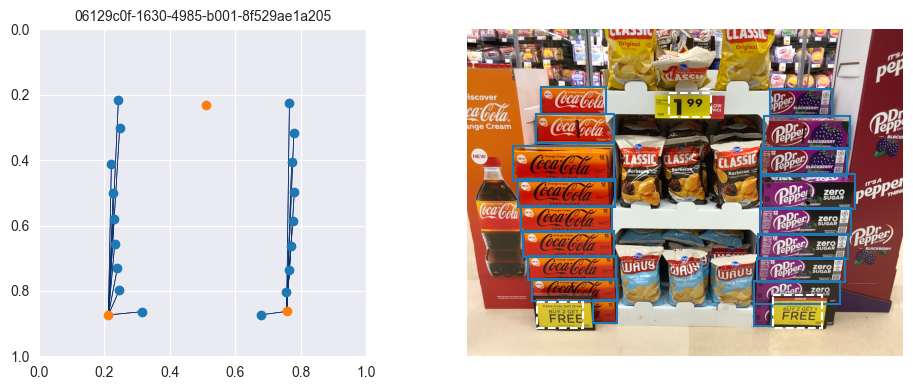

In [7]:
plot_scene_graph(idx=111, dataset=dataset, grouping="category_packaging")

In [183]:
from src.gpa.common.objects import GraphComponents, NodeGroup
from tqdm import tqdm

def add_category_and_brand_groups_to_dataset(dataset_directory: str) -> PriceAttributionDataset:
    df = pd.read_csv(Path(dataset_directory) / "raw"/ "product_boxes.csv", index_col="attributionset_id")
    raw_graph_components = torch.load(f"{dataset_directory}/raw/graph_components.pt", weights_only=True)
    components = []
    dataset = PriceAttributionDataset(root=dataset_directory)
    for raw in tqdm(raw_graph_components, total=len(raw_graph_components)):
        if raw['graph_id'] in df.index:
            scene = df.loc[[raw['graph_id']]]
            category_groups = [
                NodeGroup(id=group_id, bbox_ids=bbox_ids)
                for group_id, bbox_ids in scene.groupby('package_category_code')['prod_bbox_id']
                .apply(list)
                .items()
            ]
            brand_groups = [
                NodeGroup(id=group_id, bbox_ids=bbox_ids)
                for group_id, bbox_ids in scene.groupby('brand_code')['prod_bbox_id']
                .apply(list)
                .items()
            ]
            upc_groups = [NodeGroup(id=item['upc'], bbox_ids=item['bbox_ids']) for item in raw['upc_groups']]
            del raw['upc_groups']
            components.append(
                DetectionGraph.build(
                    GraphComponents(**raw, upc_groups=upc_groups, category_groups=category_groups, brand_groups=brand_groups)
                )
            )

    dataset.save(components, dataset.processed_paths[0])
    # Will now point to new dataset
    return PriceAttributionDataset(root=dataset_directory)

In [105]:
add_category_and_brand_groups_to_dataset(dataset_directory="../data/swire/val",)

Processing...
100%|██████████| 325/325 [00:05<00:00, 64.26it/s] 
Done!
100%|██████████| 325/325 [00:01<00:00, 226.56it/s]


PriceAttributionDataset(85)